

# 马里兰大学电池数据集研究（一）
Author：Icefish  
Date: 2022-10-14  
City: Guilin, China  


研究对象：10_16_2015_Initial capacity_SP20-1.xlsx  
电池型号：INR 18650-20R  
参数： 2000mAh，饱和电压：4.2V， 截止电压2.5V (cut-off voltage)  
(电池数据集官网)[https://web.calce.umd.edu/batteries/data.htm]


主要内容：基于Python语言，使用pandas库的read_excel函数读取数据，再分析。  
注意，read_excel要求安装依赖库openpyxl，请使用以下命令安装：  
pip install openpyxl  


In [15]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
dir_path = './10_16_2015_Initial capacity_SP20-1.xlsx'

In [16]:
data = pandas.read_excel(dir_path)  # 加载表格数据

In [2]:
print(data.columns) # 打印所有的列名称（字段名）

Index(['Data_Point', 'Test_Time(s)', 'Date_Time', 'Step_Time(s)', 'Step_Index',
       'Cycle_Index', 'Current(A)', 'Voltage(V)', 'Charge_Capacity(Ah)',
       'Discharge_Capacity(Ah)', 'Charge_Energy(Wh)', 'Discharge_Energy(Wh)',
       'dV/dt(V/s)', 'Internal_Resistance(Ohm)', 'Is_FC_Data',
       'AC_Impedance(Ohm)', 'ACI_Phase_Angle(Deg)'],
      dtype='object')


In [4]:
# 查看某一列, 注意：字段名大小写敏感
print(data['Data_Point'])

0            1
1            2
2            3
3            4
4            5
         ...  
27597    27598
27598    27599
27599    27600
27600    27601
27601    27602
Name: Data_Point, Length: 27602, dtype: int64


字段包括：'Data_Point', 'Test_Time(s)', 'Date_Time', 'Step_Time(s)', 'Step_Index',
       'Cycle_Index', 'Current(A)', 'Voltage(V)', 'Charge_Capacity(Ah)',
       'Discharge_Capacity(Ah)', 'Charge_Energy(Wh)', 'Discharge_Energy(Wh)',
       'dV/dt(V/s)', 'Internal_Resistance(Ohm)', 'Is_FC_Data',
       'AC_Impedance(Ohm)', 'ACI_Phase_Angle(Deg)'  
分别是：0数据点序号、1测试时间（s)、2测试日期、3步时间、4步序号、5循环序号、6电流（A）、7电压（V）、8充电量、9放电量、10充电能量、11放电量、12电压变化率、13内阻、14不明、15交流内阻、16相位角

In [19]:
# 读感兴趣的列
data_wanted = data.iloc[:, 0:13]
print(data_wanted.columns)
data_array = np.array(data_wanted)


Index(['Data_Point', 'Test_Time(s)', 'Date_Time', 'Step_Time(s)', 'Step_Index',
       'Cycle_Index', 'Current(A)', 'Voltage(V)', 'Charge_Capacity(Ah)',
       'Discharge_Capacity(Ah)', 'Charge_Energy(Wh)', 'Discharge_Energy(Wh)',
       'dV/dt(V/s)'],
      dtype='object')


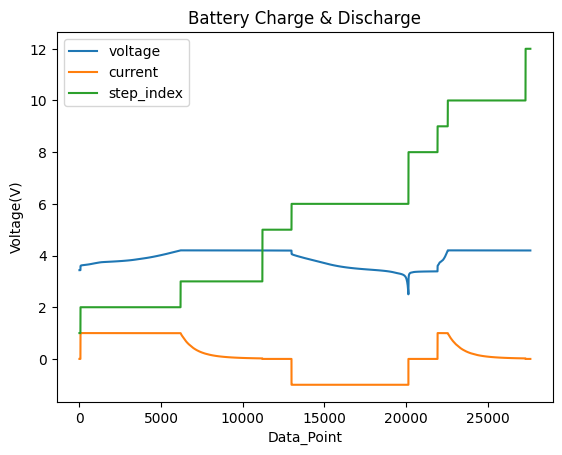

In [38]:
# 画出Voltages曲线
data_points, voltages, currents, step_indexs= data_array[:, 0], data_array[:, 7], data_array[:, 6], data_array[:, 4]
plt.figure(1)
plt.xlabel("Data_Point")
plt.ylabel("Voltage(V)")
plt.title("Battery Charge & Discharge")
plt.plot(data_points, voltages)
plt.plot(data_points, currents)
plt.plot(data_points, step_indexs)
plt.legend(["voltage", "current", "step_index"])


由上图我们可以看出，为了测量得到电池的容量：
1. 进行恒流(1A）充电(Step_Index = 2)，充电到4.2V后恒压涓流充电（Step_Index = 3)，电流下降到20mA后停止充电。
2. 静置1800s(30分钟）, (Step_Index = 5)
3. 进行恒流放电（-1A），放电到截至电压2.5V(Step_Index = 6)。

通过安时积分法，计算4.2V放电到2.5V的放电量，就能得到电池的实际容量（即毫安时）。



In [60]:
# 得到时间步（5）的持续时间
data_step5_index = data.index[data['Step_Index'] == 5]
data_step5 = data.iloc[data_step5_index, :]
end_time = data_step5.tail(1)
duration = end_time["Step_Time(s)"]
print(f'静置了{duration.values} s.')

静置了[1800.01158002] s.


In [58]:
# 计算电池实际容量： 公式： capacity = ∫idt = ΣIΔt
def capacity_compute(discharge_data):
    capacity = 0
    delta_time = 0;
    for index in range(len(discharge_data)):
        delta_time = discharge_data[index, 0] - (discharge_data[index-1, 0]) if index > 0 else discharge_data[index, 0]
        capacity = capacity + discharge_data[index, 1] * delta_time*(-1)
    return (capacity*1000/3600)  #转换为mAh
        

# 获得放电阶段的放电电流和时间数值
data_step6_index = data.index[data['Step_Index'] == 6]
data_step6 = data.iloc[data_step6_index, [3,6]]  # Step_Time(s),Current(A)
discharge_data = np.array(data_step6)
print(discharge_data)

battery_capacity = capacity_compute(discharge_data)
print(f'锂电池实际容量：{int(battery_capacity)} mAh')



[[ 1.01547567e+00 -9.99980688e-01]
 [ 2.01556426e+00 -1.00016201e+00]
 [ 3.03123173e+00 -1.00034332e+00]
 ...
 [ 7.23121766e+03 -1.00034332e+00]
 [ 7.23223326e+03 -1.00034332e+00]
 [ 7.23324889e+03 -1.00016201e+00]]
锂电池实际容量：2009 mAh


安时积分法得到的容量比标称容量还大！赚大了赚大了。
由于恒流放电，我们根据容量= 恒定电流*放电小时数来计算。

In [65]:
# 得到时间步（6）的持续时间（恒流放电时间）
data_step6_index = data.index[data['Step_Index'] == 6]
data_step6 = data.iloc[data_step6_index, :]
end_time = data_step6.tail(1)
duration = end_time["Step_Time(s)"]
print(f'持续放电{duration.values} 秒. {duration.values/3600} 小时')

# 计算容量
actual_capacity = int(1000 * duration.values/3600)
print(f'电池实际容量：{actual_capacity} mAh.')


持续放电[7233.24888647] 秒. [2.0092358] 小时
电池实际容量：2009 mAh.


从以上两种计算电池容量的算法来看，结果都是一样的。
电池实际容量为2009mAh。

--------------大功告成（mission complete）------------------  

2022-10-15  桂林